In [1]:
import os
import math
#import cv2
import tarfile
import numpy as np
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import FileLink
from IPython.display import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as T
from torchvision.transforms import ToTensor, Normalize, Compose
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url

In [2]:
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [3]:
print(os.listdir(DATA_DIR+'/images')[:10])

['46138_2014.jpg', '7909_2004.jpg', '34729_2011.jpg', '8027_2004.jpg', '54525_2016.jpg', '30701_2010.jpg', '54500_2016.jpg', '24077_2008.jpg', '42908_2013.jpg', '31625_2010.jpg']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

latent_size = 128

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

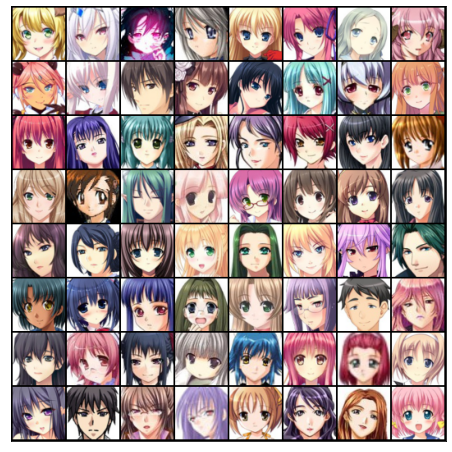

In [8]:
show_batch(train_dl)

In [12]:
def get_default_device():
    """Pick CPU for now"""
    return torch.device('cuda')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
def relu():
    return nn.ReLU()

def lrelu(f=0.2):
    return nn.LeakyReLU(f)

def tanh():
    return nn.Tanh()

def batch_norm(ni):
    return nn.BatchNorm2d(ni)

def conv_2d(ni, nf, ks, stride=2):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def deconv_2d(ni, nf, ks, stride=2, padding=1, output_padding=1):
    return nn.ConvTranspose2d(in_channels=ni, out_channels=nf, 
                               kernel_size=ks, stride=stride, 
                               padding=padding, output_padding=output_padding)
    
def fc_nn(input_size, output_size):
    return nn.Sequential(nn.Flatten(), 
                          nn.Linear(input_size, output_size)
                         )

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, ni, ks=3, stride=1):
        super().__init__()
        self.conv = conv_2d(ni, ni, ks, stride)
        self.bn = batch_norm(ni)
        self.lrelu = lrelu()
        self.shortcut = lambda x: x

    def forward(self, x):
        r = self.shortcut(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x.add_(r))
        return x

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
class GeneratorGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        
        dim = [3, 64, 128, 256, 512]
        dec = [64, 32, 16, 8]
        
        
        #Encoder
        #---------------
        
        self.conv0 = nn.Sequential(
                    conv_2d(dim[0], dim[1], ks=7, stride=1),
                    lrelu(),
                    ResBlock(dim[1], ks=7))
        
        self.conv1 = nn.Sequential(
                    conv_2d(dim[1], dim[1], ks=5, stride=2),
                    batch_norm(dim[1]),
                    lrelu(),
                    ResBlock(dim[1], ks=5))
        
        self.conv2 = nn.Sequential(
                    conv_2d(dim[1], dim[2], ks=3, stride=2),
                    batch_norm(dim[2]),
                    lrelu(),
                    ResBlock(dim[2], ks=3))
        
        self.conv3 = nn.Sequential(
                    conv_2d(dim[2], dim[3], ks=3, stride=2),
                    batch_norm(dim[3]),
                    lrelu(),
                    ResBlock(dim[3], ks=3))
        
        self.conv4 = nn.Sequential(
                    conv_2d(dim[3], dim[4], ks=3, stride=2),
                    batch_norm(dim[4]),
                    lrelu(),
                    ResBlock(dim[4], ks=3),
                    ResBlock(dim[4], ks=3),
                    ResBlock(dim[4], ks=3),
                    ResBlock(dim[4], ks=3))
        
        self.fc1 = nn.Sequential(
                    fc_nn(dim[1]*dim[4], dim[4]))

        
        
        #Decoder
        #---------------
        
        #Layer-feat8 [bs, 64, 8, 8]
        self.feat8_ = nn.Sequential(
                    fc_nn(dim[4], dim[1]*8*8))
        self.feat8 = nn.Sequential(
                    relu())
        
        #Layer-feat32 [bs, 32, 32, 32]
        self.feat32 = nn.Sequential(
                    deconv_2d(dec[0], dec[1], 3, 4, 0, 1),
                    relu())
        
        #Layer-feat64 [bs, 16, 64, 64]
        self.feat64 = nn.Sequential(
                    deconv_2d(dec[1], dec[2], 3, 2, 1, 1),
                    relu())
        
        #Layer-feat128 [bs, 8, 128, 128]
        self.feat128 = nn.Sequential(
                    deconv_2d(dec[2], dec[3], 3, 2, 1, 1),
                    relu())
    
        #Layer - deconv0 [bs, 512, 16, 16]
        self.deconv0_16 = nn.Sequential(
                    ResBlock(ni=576),
                    ResBlock(ni=576),
                    ResBlock(ni=576),
                    deconv_2d(576, dim[4], 3, 2, 1, 1),
                    batch_norm(dim[4]),
                    relu())
        
        #Layer - deconv1 [bs, 256, 32, 32]
        self.decode_16 = nn.Sequential(
                    ResBlock(ni=256))
        
        self.deconv1_32 = nn.Sequential(
                    ResBlock(ni=768),
                    ResBlock(ni=768),
                    deconv_2d(768, dim[3], 3, 2, 1, 1),
                    batch_norm(dim[3]),
                    relu())
        
        #Layer - deconv2 [bs, 128, 64, 64]
        self.decode_32 = nn.Sequential(
                    ResBlock(ni=160))
        
        self.reconstruct_32 = nn.Sequential(
                    ResBlock(ni=416),
                    ResBlock(ni=416))
        
        self.deconv2_64 = nn.Sequential(
                    deconv_2d(416, dim[2], 3, 2, 1, 1),
                    batch_norm(dim[2]),
                    relu())
        
        self.img32 = nn.Sequential(
                    conv_2d(ni=416, nf=dim[0], ks=3, stride=1),
                    tanh())
        
        #Layer - deconv3 [bs, 64, 128, 128]
        self.decode_64 = nn.Sequential(
                    ResBlock(ni=80, ks=5))
        
        self.reconstruct_64 = nn.Sequential(
                    ResBlock(ni=211),
                    ResBlock(ni=211))
        
        self.deconv3_128 = nn.Sequential(
                    deconv_2d(211, dim[1], 3, 2, 1, 1),
                    batch_norm(dim[1]),
                    relu())
        
        self.img64 = nn.Sequential(
                    conv_2d(ni=211, nf=dim[0], ks=3, stride=1),
                    tanh())
        
#         #Layer - conv5 [bs, 64, 128, 128]
#         self.decode_128 = nn.Sequential(
#                     ResBlock(ni=75, ks=7))
        
#         self.reconstruct_128 = nn.Sequential(
#                     ResBlock(ni=209, ks=5))
        
#         self.conv5 = nn.Sequential(
#                     conv_2d(209, dec[0], ks=5, stride=1),
#                     batch_norm(dec[0]),
#                     lrelu(),
#                     ResBlock(ni=dec[0]))

#         #Layer - conv6 [bs, 32, 128, 128]
#         self.conv6 = nn.Sequential(
#                     conv_2d(dec[0], dec[1], ks=3, stride=1),
#                     batch_norm(dec[1]),
#                     lrelu())
        
#         #Layer - conv7 [bs, 3, 128, 128]
#         self.img128 = nn.Sequential(
#                     conv_2d(ni=dec[1], nf=dim[0], ks=3, stride=1),
#                     tanh())

    
    def forward(self, I_P_128):
        #noise = torch.randn(128, 256)
        conv0 = self.conv0(I_P_128)
        conv1 = self.conv1(conv0)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        fc1 = self.fc1(conv4)
        fc2 = torch.maximum(fc1[:, 0:256], fc1[:, 256:])
        
        #feat8_ = self.feat8_(torch.cat((fc2, noise), 1)).view(fc2.size()[0], 64, 8, 8) #Output: [bs, 64, 8, 8]
        feat8_ = self.feat8_(fc1).view(fc1.size()[0], 64, 8, 8) #Output: [bs, 64, 8, 8]
        
        feat8 = self.feat8(feat8_) #Output: [bs, 64, 8, 8]
        
        feat32 = self.feat32(feat8) #Output: [bs, 32, 32, 32]
        
        feat64 = self.feat64(feat32) #Output: [bs, 16, 64, 64]
        
        feat128 = self.feat128(feat64) #Output: [bs, 8, 128, 128]
        
        deconv0_16 = self.deconv0_16(torch.cat((feat8, conv4), 1)) #Output: [bs, 512, 16, 16]
        
        decode_16 = self.decode_16(conv3)
        deconv1_32 = self.deconv1_32(torch.cat((deconv0_16, decode_16), 1)) #Output: [bs, 256, 32, 32]
        
        decode_32 = self.decode_32(torch.cat((conv2, feat32), 1))
        reconstruct_32 = self.reconstruct_32(torch.cat((deconv1_32, decode_32), 1))
        deconv2_64 = self.deconv2_64(reconstruct_32) #Output: [bs, 128, 64, 64]
        img32 = self.img32(reconstruct_32) #Output: [bs, 3, 32, 32]
        
        decode_64 = self.decode_64(torch.cat((conv1, feat64), 1))
        reconstruct_64 = self.reconstruct_64(torch.cat((deconv2_64, decode_64, \
                                                       F.interpolate(img32, (64,64), \
                                                                     mode='bilinear', align_corners=False)), 1))
        deconv3_128 = self.deconv3_128(reconstruct_64) #Output: [bs, 64, 128, 128]
        img64 = self.img64(reconstruct_64) #Output: [bs, 3, 64, 64]
        
        # decode_128 = self.decode_128(torch.cat((conv0, feat128, I_P_128), 1))
        # #Concatenated eyel, eyer, nose, mouth, c_eyel, c_eyer, c_nose, c_mouth
        # reconstruct_128 = self.reconstruct_128(torch.cat((deconv3_128, decode_128, \
        #                                                F.interpolate(img64, (128,128), \
        #                                                              mode='bilinear', align_corners=False), \
        #                                                  local_feature, local_predict), 1)) 
        # conv5 = self.conv5(reconstruct_128) #Output: [bs, 64, 128, 128]
        
        # conv6 = self.conv6(conv5) #Output: [bs, 32, 128, 128]
        
        # img128 = self.img128(conv6) #Output: [bs, 3, 128, 128]
        
        
        return img64
        #return img128, img64, img32, fc2

In [ ]:
xb = torch.randn(batch_size, 3, 128, 128) # random latent tensors
#noi = torch.randn(batch_size, 256)

generator = GeneratorGlobal()
fake_images = generator(xb)
print(fake_images.shape)

In [ ]:
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, 3, 128, 128, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, 3, 128, 128, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, 3, 128, 128, device=device)

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 1

In [ ]:
history = fit(epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');